In [1]:
import mne
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import pairwise_distances
from nltools.data import Brain_Data, Design_Matrix, Adjacency
import networkx as nx
from scipy import signal
from mne_connectivity import spectral_connectivity_epochs
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import io
from itertools import cycle
from matplotlib.lines import Line2D
from scipy.fft import fft, fftfreq
from scipy.stats import pearsonr
from matplotlib.animation import FuncAnimation, PillowWriter



from functions.EpiIndex import *
from functions.Connectivity import *

Here we are going to calculate some metrics using the matrix for every band as a temporal network 


In [2]:
raw=mne.io.read_raw_fif('/home/pablo/works/dev_thesis_SEEG/data/pte_01/sets/segments_ictal_SR/ictal-epo_6.fif', preload=True)
#Reading a npy file 
data_alpha = np.load('/home/pablo/works/dev_thesis_SEEG/outputs/pte_01/pte_01_connectivity_data_alpha_aec_dense.npy')
data_beta = np.load('/home/pablo/works/dev_thesis_SEEG/outputs/pte_01/pte_01_connectivity_data_beta_aec_dense.npy')
data_hgamma = np.load('/home/pablo/works/dev_thesis_SEEG/outputs/pte_01/pte_01_connectivity_data_high_gamma1_aec_dense.npy')
data_lgamma = np.load('/home/pablo/works/dev_thesis_SEEG/outputs/pte_01/pte_01_connectivity_data_low_gamma_aec_dense.npy')
data_theta = np.load('/home/pablo/works/dev_thesis_SEEG/outputs/pte_01/pte_01_connectivity_data_theta_aec_dense.npy')


#Data with other metrics
data_coh = np.load('/home/pablo/works/dev_thesis_SEEG/outputs/pte_01/SR_subseg_connectivity_data_high_freq_coh_dense.npy')[:,:,:,0]
# Assuming data is the array with shape (50, 127, 127)
for i in range(data_coh.shape[0]):
    # Extract the lower triangular part (including the diagonal)
    lower_triangular = np.tril(data_coh[i])
    
    # Mirror the lower triangular part to the upper triangular part
    data_coh[i] = lower_triangular + lower_triangular.T - np.diag(np.diag(lower_triangular))

#Make data_coh symmetric

# con_data=np.mean(data,axis=3)

Opening raw data file /home/pablo/works/dev_thesis_SEEG/data/pte_01/sets/segments_ictal_SR/ictal-epo_6.fif...


Isotrak not found
    Range : 4681728 ... 4866048 =   9144.000 ...  9504.000 secs
Ready.
Reading 0 ... 184320  =      0.000 ...   360.000 secs...


/tmp/ipykernel_109615/4232828393.py:1: RuntimeWarning: This filename (/home/pablo/works/dev_thesis_SEEG/data/pte_01/sets/segments_ictal_SR/ictal-epo_6.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw=mne.io.read_raw_fif('/home/pablo/works/dev_thesis_SEEG/data/pte_01/sets/segments_ictal_SR/ictal-epo_6.fif', preload=True)


## Topological overlap

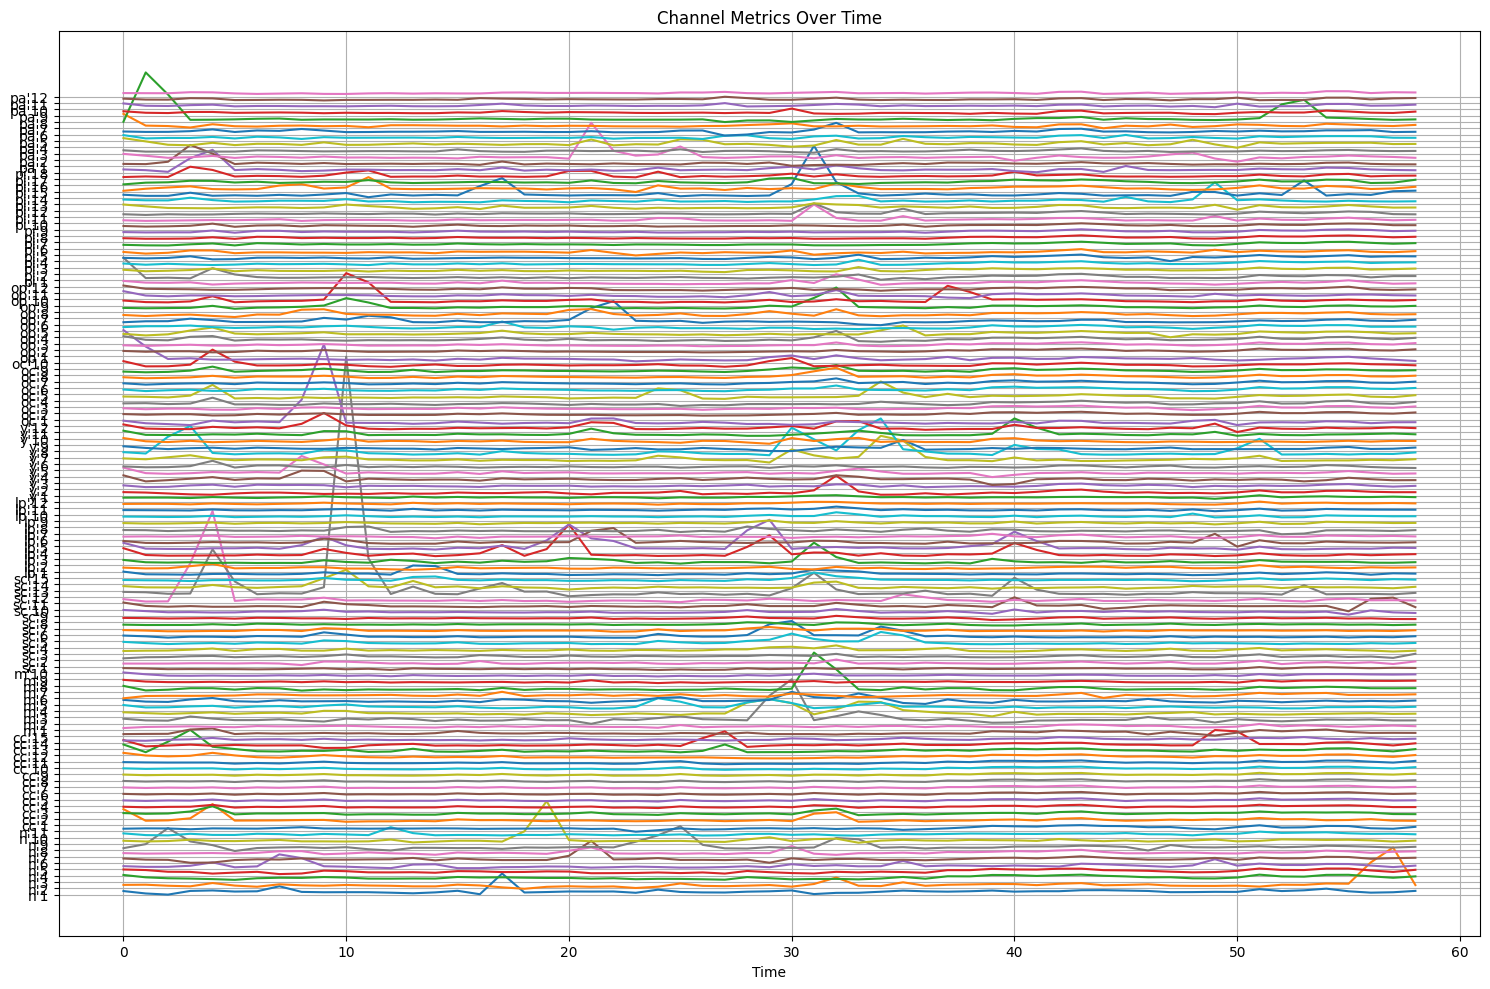

In [10]:
data=data_alpha
CIi_t=np.zeros((data.shape[0]-1,data.shape[1]))

for t in range(0, data.shape[0]-1):
    num=0
    root1=0
    root2=0
    for i in range(0, data.shape[1]):
        num=np.sum(data[t,i,:] * data[t+1,i,:])
        root1=np.sum(data[t,i,:])
        root2=np.sum(data[t+1,i,:])
        CIi_t[t,i]=num/(np.sqrt(np.abs(root1*root2)))
    
offset = 0.5 # This offset will determine the spacing between lines
ch_names=raw.info['ch_names']
rescaled_data = CIi_t + np.arange(CIi_t.shape[1]) * offset

# Create the plot
plt.figure(figsize=(15, 10))
for i in range(CIi_t.shape[1]):
    plt.plot(rescaled_data[:, i], label=ch_names[i])

# Customize the plot
plt.yticks(np.arange(len(ch_names)) * offset, ch_names)  # Set the y-ticks to the channel names
plt.xlabel('Time')
plt.title('Channel Metrics Over Time')
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.show()

# Average topological overlap 

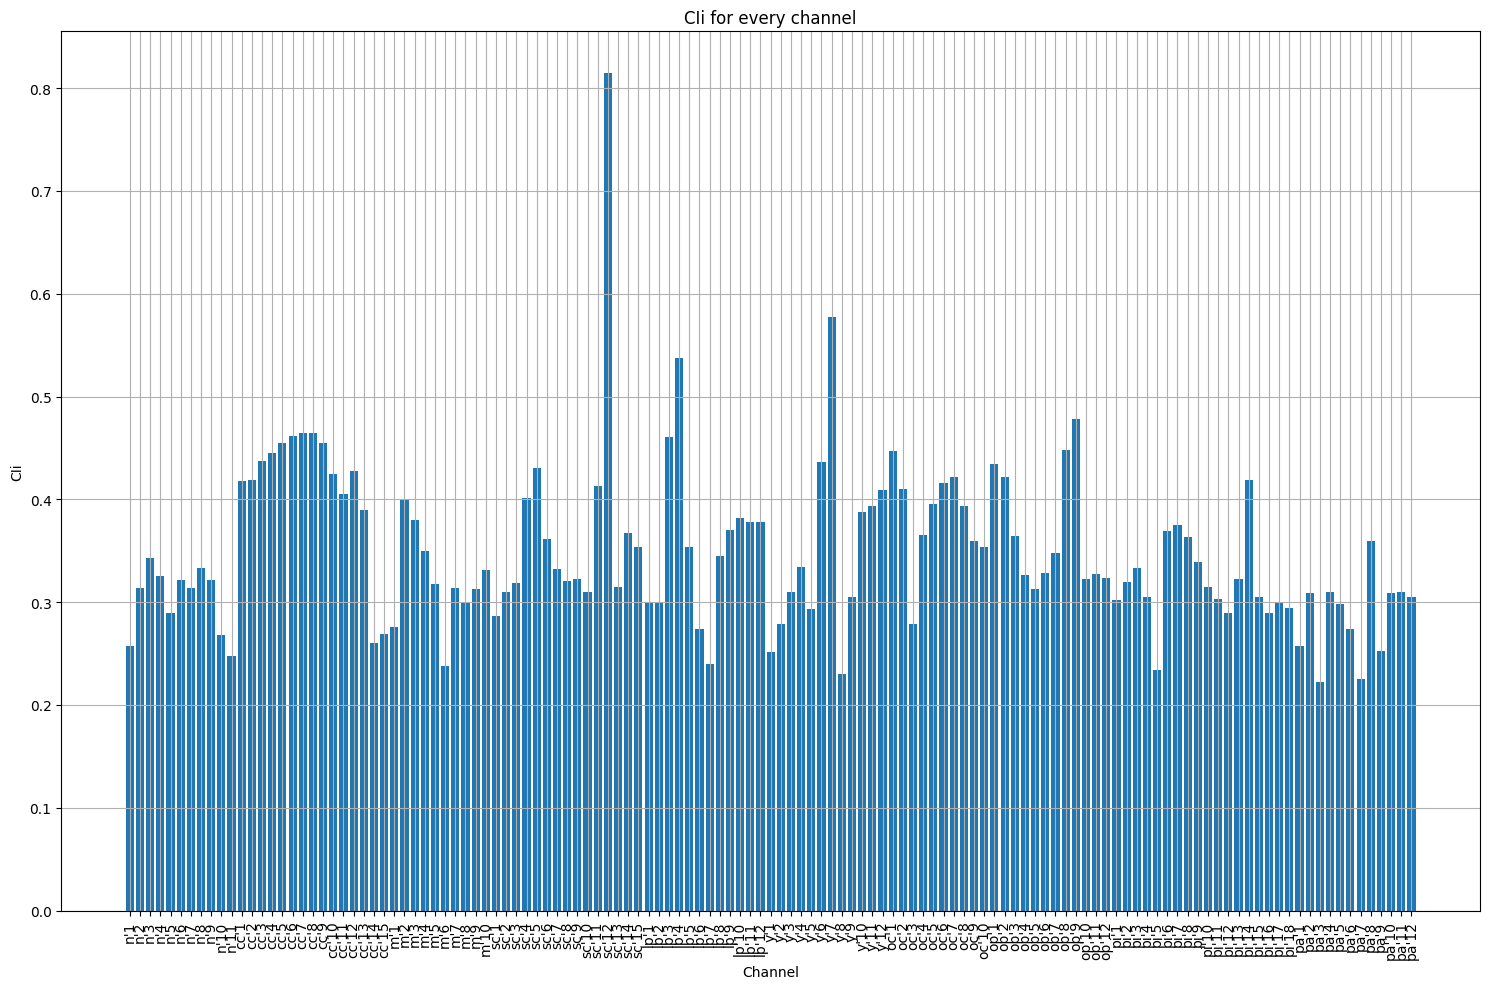

In [11]:
#Average over time for every channel 
CIi=np.mean(CIi_t,axis=0)

#Plot a hist of every channel
plt.figure(figsize=(15, 10))
plt.bar(ch_names,CIi)
plt.xlabel('Channel')
plt.xticks(rotation=90)
plt.ylabel('CIi')
plt.title('CIi for every channel')
plt.grid(True)
plt.tight_layout()
plt.show()


# Correlation analysis

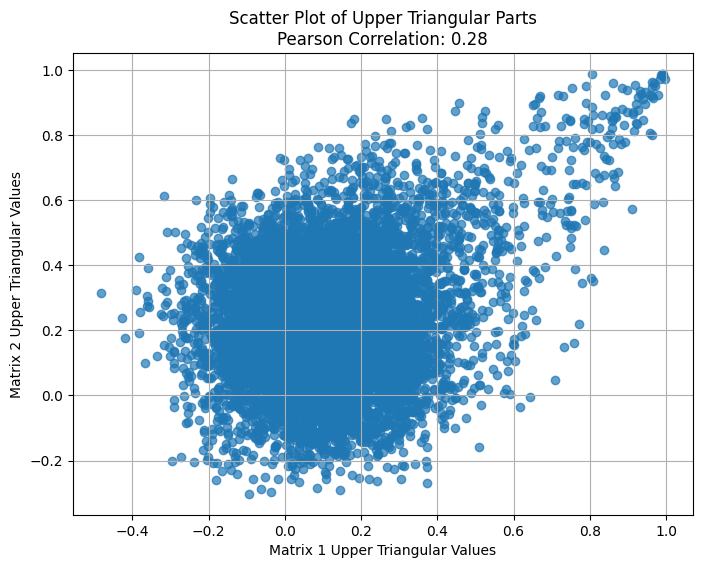

Pearson correlation coefficient: 0.28
P-value: 1.56e-148


In [12]:
t=26
# Extract the upper triangular parts, excluding the diagonal
upper_tri_1 = data[t,:,:][np.triu_indices_from(data[t,:,:], k=1)]
upper_tri_2 = data[t+1,:,:][np.triu_indices_from(data[t+1,:,:], k=1)]

# Calculate Pearson correlation coefficient
correlation, p_value = pearsonr(upper_tri_1, upper_tri_2)

# Create scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(upper_tri_1, upper_tri_2, alpha=0.7)
plt.title(f'Scatter Plot of Upper Triangular Parts\nPearson Correlation: {correlation:.2f}')
plt.xlabel('Matrix 1 Upper Triangular Values')
plt.ylabel('Matrix 2 Upper Triangular Values')
plt.grid(True)
plt.show()

print(f"Pearson correlation coefficient: {correlation:.2f}")
print(f"P-value: {p_value:.2e}")


In [13]:
# Create a figure and axis
fig, ax = plt.subplots(figsize=(8, 6))

# Function to update the plot for each frame
def update(t):
    ax.clear()  # Clear previous scatter plot
    # Extract the upper triangular parts, excluding the diagonal
    upper_tri_1 = data[t, :, :][np.triu_indices_from(data[t, :, :], k=1)]
    upper_tri_2 = data[t + 1, :, :][np.triu_indices_from(data[t + 1, :, :], k=1)]

    # Calculate Pearson correlation coefficient
    correlation, p_value = pearsonr(upper_tri_1, upper_tri_2)

    # Create scatter plot
    ax.scatter(upper_tri_1, upper_tri_2, alpha=0.7)
    ax.set_title(f'Scatter Plot of Upper Triangular Parts (t={t})\nPearson Correlation: {correlation:.2f} \n P-value: {p_value:.2e}')
    ax.set_xlabel('Matrix 1 Upper Triangular Values')
    ax.set_ylabel('Matrix 2 Upper Triangular Values')
    ax.grid(True)

# Number of time steps
time_steps = data.shape[0] - 1

# Create an animation
ani = FuncAnimation(fig, update, frames=time_steps, repeat=False)

# Save the animation as a GIF
ani.save('scatter_plot_animation.gif', writer=PillowWriter(fps=2))

plt.close()

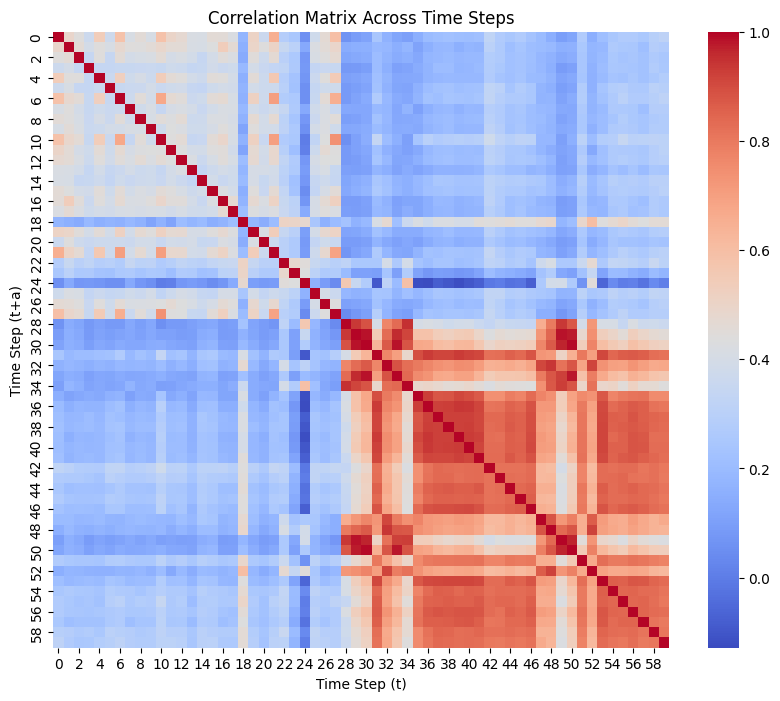

In [82]:

# Number of time steps
time_steps = data.shape[0]

# Initialize an empty correlation matrix
correlation_matrix = np.zeros((time_steps, time_steps))

# Loop through all pairs of time steps (t, t+a)
for t1 in range(time_steps):
    for t2 in range(time_steps):
        # Extract the upper triangular parts, excluding the diagonal
        upper_tri_1 = data[t1, :, :][np.triu_indices_from(data[t1, :, :], k=1)]
        upper_tri_2 = data[t2, :, :][np.triu_indices_from(data[t2, :, :], k=1)]

        # Calculate Pearson correlation coefficient
        correlation, p_value = pearsonr(upper_tri_1, upper_tri_2)

        # Store the correlation in the matrix
        correlation_matrix[t1, t2] = correlation

# Plot the correlation matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, fmt=".2f", cmap='coolwarm', square=True)
plt.title("Correlation Matrix Across Time Steps")
plt.xlabel("Time Step (t)")
plt.ylabel("Time Step (t+a)")
plt.show()

In [114]:
#Analize t=29 and t=30 
t1=0
t2=1

# Extract the upper triangular parts, excluding the diagonal
upper_tri_1 = data[t1, :, :][np.triu_indices_from(data[t1, :, :], k=1)]
upper_tri_2 = data[t2, :, :][np.triu_indices_from(data[t2, :, :], k=1)]
scatter=np.array([upper_tri_1,upper_tri_2]).T
#Get an array of the tuples with the names of the channels
ch_names_tup=[(ch_names[i],ch_names[j]) for i,j in zip(np.triu_indices_from(data[t1, :, :], k=1)[0],np.triu_indices_from(data[t1, :, :], k=1)[1])]



In [117]:
#We are going to calculate a kmeans clustering of the scatter plot, and then say which channels are in the same cluster
from sklearn.cluster import KMeans

# Number of clusters
n_clusters = 2

# Create a KMeans model
kmeans = KMeans(n_clusters=n_clusters, random_state=42)

# Fit the model to the data
kmeans.fit(scatter)

# Get the cluster labels
cluster_labels = kmeans.labels_

# Create a DataFrame with the channel names and cluster labels
df = pd.DataFrame({'Channel Pair': ch_names_tup, 'Cluster': cluster_labels})

# Sort the DataFrame by cluster
df = df.sort_values('Cluster').reset_index(drop=True)

# Display the DataFrame
print(df)


        Channel Pair  Cluster
0         (n'1, n'2)        0
1        (m'7, pi'5)        0
2         (m'8, m'9)        0
3        (m'8, m'10)        0
4        (m'9, m'10)        0
...              ...      ...
7996   (cc'15, pi'2)        1
7997   (cc'15, pi'1)        1
7998  (cc'15, op'12)        1
7999  (cc'15, pi'12)        1
8000     (sc'4, y'1)        1

[8001 rows x 2 columns]


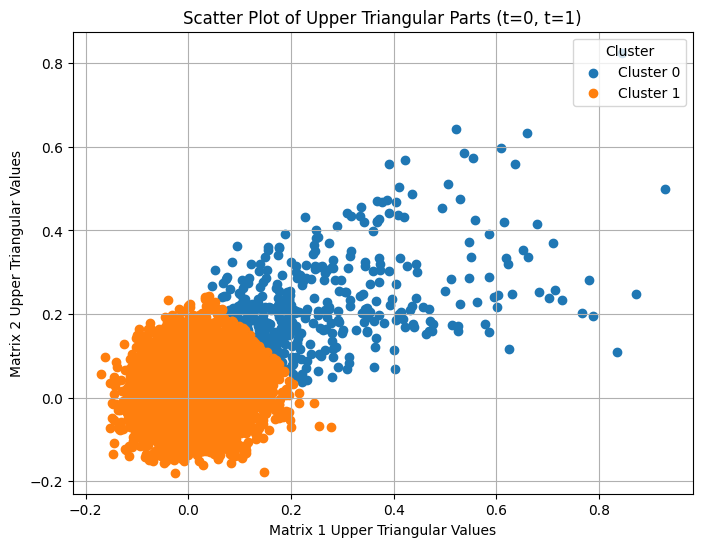

In [118]:
#Show the scatter plot with the clusters
# Create a figure and axis
fig, ax = plt.subplots(figsize=(8, 6))

# Create a color cycle for the clusters
colors = cycle(sns.color_palette('tab10', n_clusters))

# Loop through each cluster
for cluster in range(n_clusters):
    # Get the indices of the scatter points in the cluster
    cluster_indices = np.where(cluster_labels == cluster)[0]

    # Get the color for the cluster
    color = next(colors)

    # Plot the scatter points for the cluster
    ax.scatter(scatter[cluster_indices, 0], scatter[cluster_indices, 1], label=f'Cluster {cluster}', color=color)

# Customize the plot
ax.set_title(f'Scatter Plot of Upper Triangular Parts (t={t1}, t={t2})')
ax.set_xlabel('Matrix 1 Upper Triangular Values')
ax.set_ylabel('Matrix 2 Upper Triangular Values')
ax.legend(title='Cluster', loc='upper right')
ax.grid(True)

# Show the plot
plt.show()

In [122]:
#Extract the unique values of the channels in the tuples, for the first component, and the second component of the tuple
unique_channels=np.unique(np.array(ch_names_tup).flatten())
uniques_1=np.unique(np.array(ch_names_tup)[:,0])
uniques_2=np.unique(np.array(ch_names_tup)[:,1])



In [125]:
len(uniques_1)

126

In [121]:
# #Make a plot, with the channels in the same cluster in the same color
# # Create a figure and axis
# fig, ax = plt.subplots(figsize=(10, 8))

# # Create a color cycle for the clusters
# colors = cycle(sns.color_palette('tab10', n_clusters))

# # Loop through each cluster

# for cluster in range(n_clusters):
#     # Get the indices of the scatter points in the cluster
#     cluster_indices = np.where(cluster_labels == cluster)[0]

#     # Get the color for the cluster
#     color = next(colors)

#     # Loop through each channel pair in the cluster
#     for i in cluster_indices:
#         # Get the channel pair
#         channel_pair = ch_names_tup[i]

#         # Get the channel indices
#         ch1_idx = ch_names.index(channel_pair[0])
#         ch2_idx = ch_names.index(channel_pair[1])

#         # Plot the channel pair
#         ax.plot([ch1_idx, ch2_idx], [t1, t2], color=color)

# # Customize the plot
# ax.set_yticks(range(data.shape[0]))
# ax.set_yticklabels(range(data.shape[0]))
# ax.set_ylabel('Time Step')

# ax.set_xticks(range(len(ch_names)))
# ax.set_xticklabels(ch_names, rotation=90)
# ax.set_xlabel('Channel')

# ax.set_title(f'Channel Pairs in Clusters (t={t1}, t={t2})')
# ax.grid(True)

# # Create a custom legend
# legend_elements = [Line2D([0], [0], color='black', label=f'Cluster {cluster}') for cluster in range(n_clusters)]
# ax.legend(handles=legend_elements, title='Cluster', loc='upper right')

# # Show the plot
# plt.tight_layout()
# plt.show()